インポート

In [1]:
import numpy as np
import soundfile as sf
import librosa
import pickle as pic
import scipy.signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import pyroomacoustics as pra
from scipy.io import wavfile
# temp
#from SS01_ILRMA import ILRMA

パラメータ設定

In [ ]:
SOUND_SPEED = 340. # 音速
SAMPLING_RATE = 16000  # 保存するときのサンプリングレート
N_FFT = 1024  # STFTをするときの窓幅
HOP_LENGTH = 256  # STFTをするときのシフト幅（オーバラップをどれだけにするか）
F = int(N_FFT/2 + 1)  # STFTしたあとの周波数ビンの数

マイクのある部屋をシュミレート

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

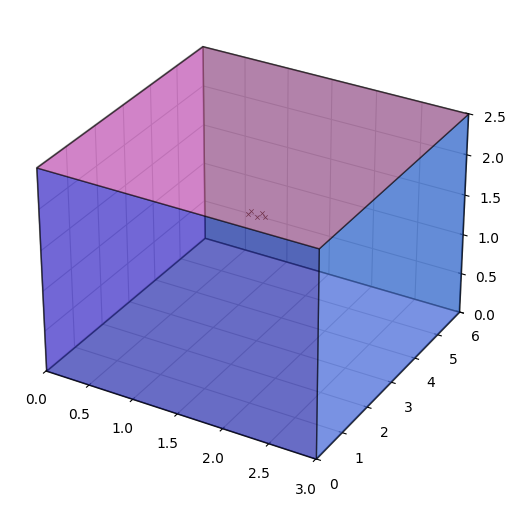

In [ ]:
# make room
absorption = 0.6  # 吸音率
MAX_REFRECTION_ORDER = 10 # 反射の最大回数
corners = np.array([[0,0], [0,6], [3,6], [3,0]]).T  # [x,y] (meter)
room = pra.Room.from_corners(corners, materials=pra.Material(absorption), fs=SAMPLING_RATE, t0=0.0, max_order=MAX_REFRECTION_ORDER, sigma2_awgn=None, sources=None, mics=None)
room.extrude(2.5)  # 高さを構築し三次元化

# 部屋の中心点を計算
center_x = (0 + 3) / 2  # x座標の中心
center_y = (0 + 6) / 2  # y座標の中心
center_z = 1.6  # 高さは人の耳の高さ

# 円形マイクアレイの半径とチャンネル数
m = 5
radius = 0.1  # 半径（メートル）


# マイクの位置を計算　等間隔の角度に分割
angles = np.linspace(0, 2 * np.pi, m, endpoint=False)  # 各マイクの角度
MIC_POSITIONS = np.array([
    center_x + radius * np.cos(angles),
    center_y + radius * np.sin(angles),
    np.full(m, center_z)  # 高さは一定
])  # 形状 (3, n_mics)

# マイクアレイを部屋に追加
mic_array = pra.MicrophoneArray(MIC_POSITIONS, room.fs)
room.add_microphone_array(mic_array)

# 結果の表示
room.plot()


音源設定

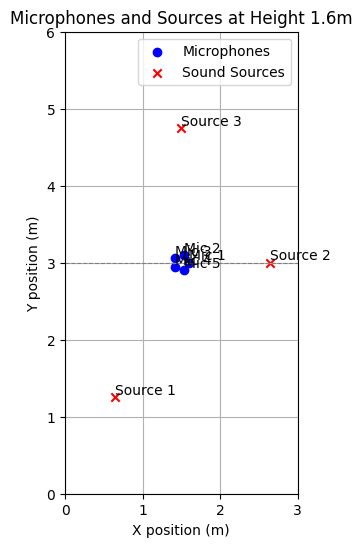

In [4]:
# 3つの音源の位置（x, y, z）
SOUND_POSITIONS = np.array([
    [center_x - 0.85, center_y - 1.75, 1.6],       # 左側の音源
    [center_x + 1.15, center_y, 1.6],       # 右側の音源
    [center_x, center_y + 1.75, 1.6],        # 上側の音源
])



filename_list = ["data/arctic_a0002.wav", "data/arctic_a0086.wav", "data/arctic_b0540.wav"]
N = max(len(SOUND_POSITIONS), len(filename_list))  # 音源数
M = len(MIC_POSITIONS)  # マイク数


_, audio1 = wavfile.read(filename_list[0])
_, audio2 = wavfile.read(filename_list[1])
_, audio3 = wavfile.read(filename_list[2])
room.add_source(position=SOUND_POSITIONS[0], signal=audio1, delay=0)
room.add_source(position=SOUND_POSITIONS[1], signal=audio2, delay=0)
room.add_source(position=SOUND_POSITIONS[2], signal=audio3, delay=0)




# 2Dプロット設定（高さ1.6の平面で切り取る）
plt.figure(figsize=(3, 6))  # 図のサイズを指定
plt.title("Microphones and Sources at Height 1.6m")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.xlim(0, 3)
plt.ylim(0, 6)

# マイクの位置をプロット
plt.scatter(MIC_POSITIONS[0], MIC_POSITIONS[1], label='Microphones', color='blue', marker='o')
# 音源の位置をプロット
plt.scatter(SOUND_POSITIONS[:, 0], SOUND_POSITIONS[:, 1], label='Sound Sources', color='red', marker='x')
# ラベルの追加
for i, pos in enumerate(SOUND_POSITIONS):
    plt.text(pos[0], pos[1], f'Source {i + 1}', fontsize=10, verticalalignment='bottom')
for i, pos in enumerate(MIC_POSITIONS.T):
    plt.text(pos[0], pos[1], f'Mic {i + 1}', fontsize=10, verticalalignment='bottom')

plt.axhline(y=center_y, color='gray', linestyle='--', linewidth=0.8)  # 中心線を描画
plt.grid()  # グリッドを表示
plt.legend()  # 凡例を表示




生成した音声の可視化

In [ ]:
# 生成した音声の可視化・確認
def visualize_spec(Z_FTN):
    for n in range(Z_FTN.shape[2]):
        signal = librosa.core.istft(Z_FTN[:, :, n], hop_length=int((F-1)/2))
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
        plt.imshow(np.log(np.abs(Z_FTN[:, :, n]) +
                          1.0e-8), origin='lower', aspect="auto")
        plt.show()
        ipd.display(ipd.Audio(signal, rate=SAMPLING_RATE))

def visualize_wav(wav_MT):
    M, T = wav_MT.shape

    for m in range(M):
        spec = librosa.core.stft(
            wav_MT[m], n_fft=N_FFT, hop_length=int(N_FFT/4))
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
        plt.imshow(np.log(np.abs(spec) + 1.0e-8),
                   origin='lower', aspect="auto")
        plt.show()
        ipd.display(ipd.Audio(wav_MT[m], rate=SAMPLING_RATE))

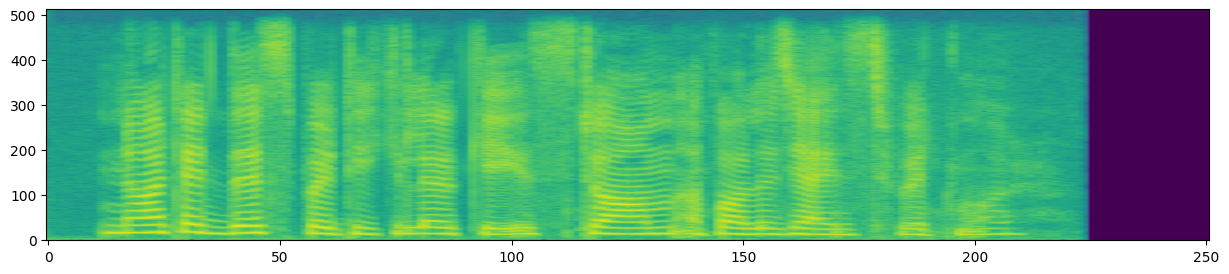

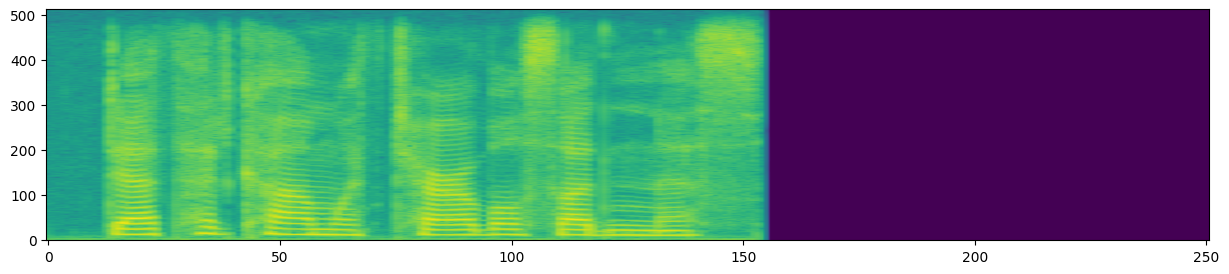

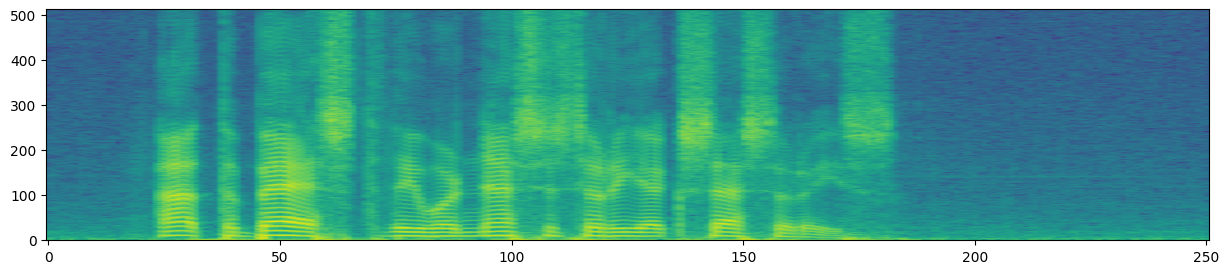

In [6]:
wav_list = []

for filename in filename_list:
    wav, fs = sf.read(filename)
    wav_list.append(wav)

max_length = max(map(len, wav_list))
wav_NT = np.zeros([N, max_length])  # 長さを揃えた N x Lengthの信号

for n in range(N):
    wav_NT[n, :len(wav_list[n])] = wav_list[n]

visualize_wav(wav_NT)

In [7]:
def convolve_RIR(signal_NT):
    convolved_signals = []
        # 指定した条件での音源からマイクまでの音の伝達をシミュレート
    room.simulate()
    mixture_signal_MT = room.mic_array.signals
    mixture_signal_MT /= np.abs(mixture_signal_MT).max() * 1.2
    
    return mixture_signal_MT

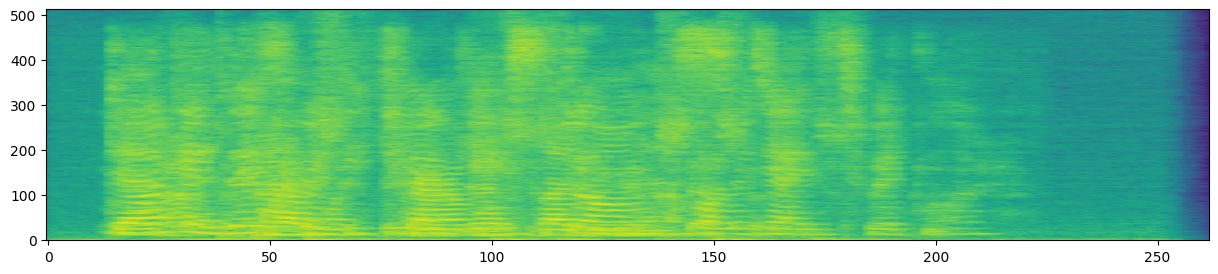

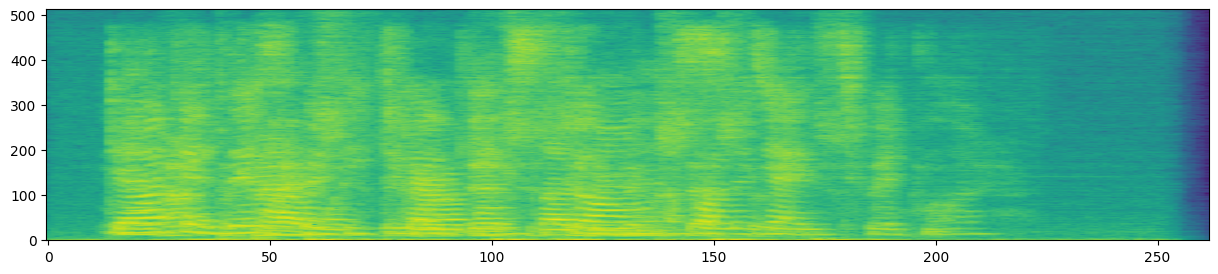

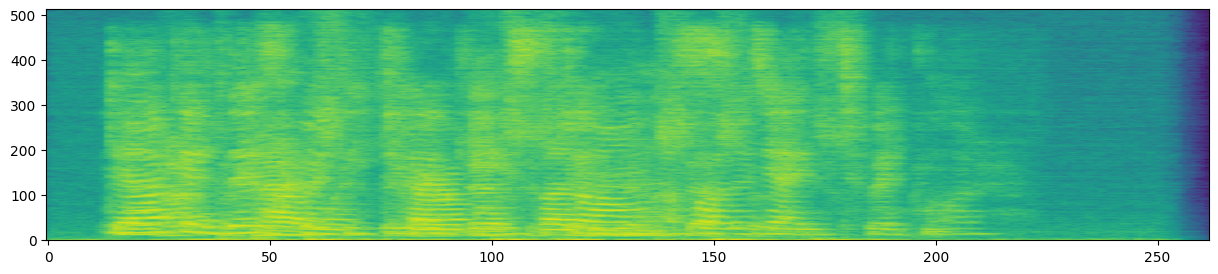

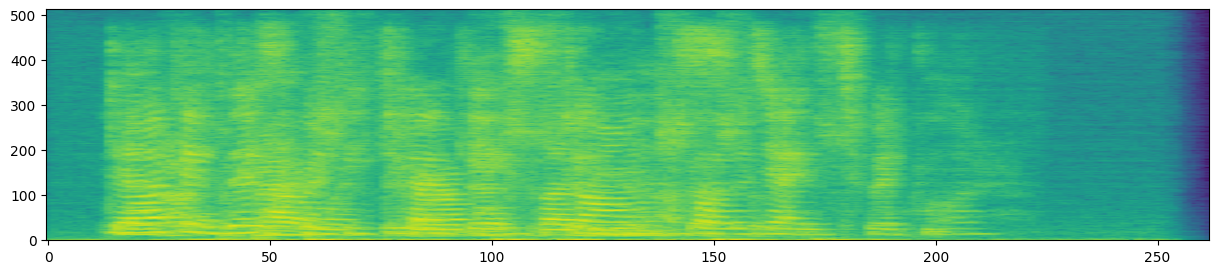

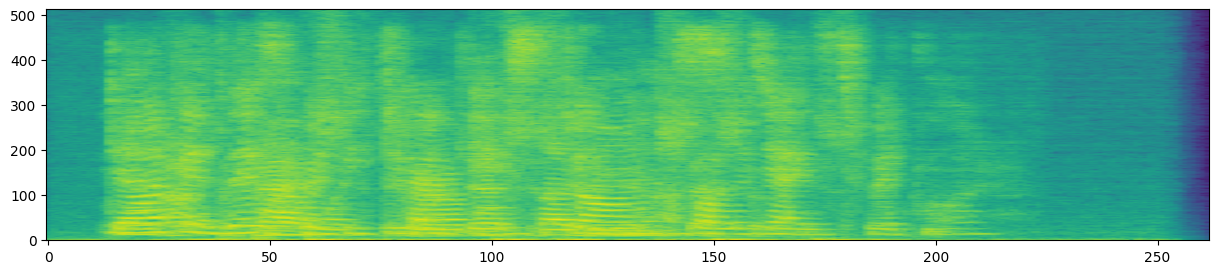

In [8]:
mixture_signal_MT = convolve_RIR(wav_NT)
sf.write("data/mixture_time_domain.wav", mixture_signal_MT.T, 16000)

visualize_wav(mixture_signal_MT)